In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import cmocean as ocm
import numpy as np
import sys
from ipywidgets import interact
import cmocean.cm as ocm

sys.path.append(os.path.join(os.environ.get('srcdir')))

from features.rotate_vector_roms import rotate_vector_roms

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# load tides and no tides hourly melting over two month
file_path = os.path.join(os.environ.get('rawdir'),'waom10_hot','ocean_his.nc')
hot = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

file_path = os.path.join(os.environ.get('rawdir'),'waom10_cold','ocean_his.nc')
cold = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})

grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_grd_patched_smooth.nc')
grd = xr.open_dataset(grid_path)

hot['ocean_time']=cold.ocean_time

In [3]:
for ds in [hot,cold]:
    ds['m'] = ds.m*(3600*24*365)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.dpi = 300
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

# Area integrated melt rate evolution

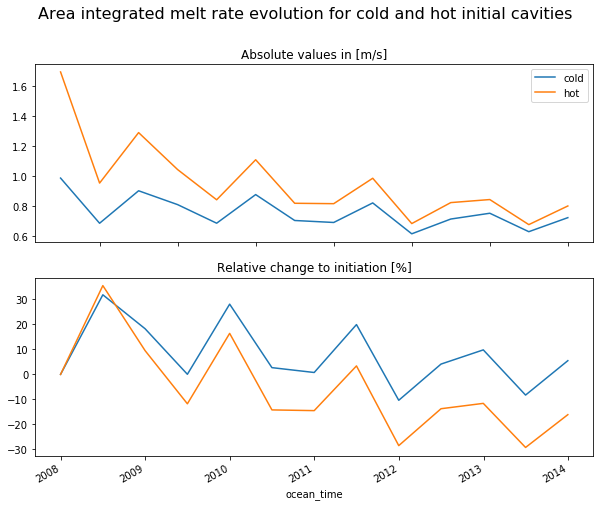

In [5]:
m_cold = cold.m.where((grd.mask_rho==1)&(grd.zice<0.0))
m_hot = hot.m.where((grd.mask_rho==1)&(grd.zice<0.0))

dA = (1.0/(grd.pm *grd.pn)).where((grd.mask_rho==1) & (grd.zice<0.0))
weights = (dA/dA.sum())

m_avg_hot = (m_hot*weights).sum(['eta_rho','xi_rho'])[1:]
m_rel_hot = ((m_avg_hot[1:]-m_avg_hot[1])/m_avg_hot[1]*100)
m_avg_cold = (m_cold*weights).sum(['eta_rho','xi_rho'])[1:]
m_rel_cold = ((m_avg_cold[1:]-m_avg_cold[1])/m_avg_cold[1]*100)

plt.close()
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,8))
plt.suptitle('Area integrated melt rate evolution for cold and hot initial cavities',fontsize=16)
m_avg_cold.plot(ax=ax1,label='cold')
m_avg_hot.plot(ax=ax1,label='hot')
ax1.set_title('Absolute values in [m/s]')
ax1.legend()

m_rel_cold.plot(ax=ax2,label='cold')
m_rel_hot.plot(ax=ax2,label='hot')
ax2.set_title('Relative change to initiation [%]')

#plt.tight_layout()
plt.show()

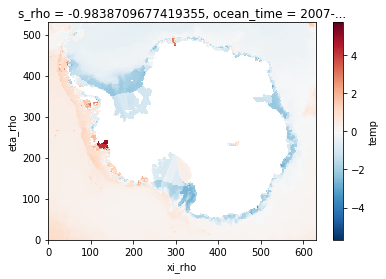

In [6]:
plt.close()
hot.temp[0,0].plot()
plt.show()

In [7]:
hot.m[time].plot

NameError: name 'time' is not defined

In [8]:
plt.close()
eta = slice(310,370)
xi = range(470,570)
m_min=-0.1
m_max=1
m_cmap = shiftedColorMap(plt.cm.bwr,midpoint= (1 - m_max/(m_max + abs(m_min))))

t_min = -2.5
t_max = -0.5
t_cmap = ocm.thermal

def melt_widget(time):
    
    fig,axes = plt.subplots(2,2,figsize=(15,10))
    ax1,ax2,ax3,ax4 = axes.flatten()
    hot.m[time].where((grd.zice < 0.0)&(grd.mask_rho==1)).plot(ax=ax1,vmin=m_min,vmax=m_max,cmap=m_cmap)
    ax1.set_title('Melt rate in m/yr')
    cold.m[time].where((grd.zice < 0.0)&(grd.mask_rho==1)).plot(ax=ax2,vmin=m_min,vmax=m_max,cmap=m_cmap)
    hot.temp[time,0].where((grd.mask_rho==1) & (grd.h<2500)).plot(ax=ax3,vmin=t_min,vmax=t_max,cmap=t_cmap)
    ax3.set_title('Bottom temp in degC')
    cold.temp[time,0].where((grd.mask_rho==1) & (grd.h<2500)).plot(ax=ax4,vmin=t_min,vmax=t_max,cmap=t_cmap)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_aspect('equal')
        ax.axis('off')
    fig.tight_layout()
    plt.show()

interact(melt_widget,time = range(hot.ocean_time.size))

interactive(children=(Dropdown(description='time', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), value=0), Output()), _dom_classes=('widget-interact',))

<function __main__.melt_widget>

In [2]:
from pandas import datetime
path = os.path.join(os.environ.get('rawdir'),'hre10_stable','ocean_avg_nudg_0006.nc')
winter = xr.open_dataset(path).isel(ocean_time=10)
#path = os.path.join(os.environ.get('rawdir'),'hre4','ocean_his_20141230.nc')
summer = xr.open_dataset(path).isel(ocean_time=2)
s2a = 3600*24*365
for ds in [summer,winter]:
    ds['m'] = ds.m*s2a

path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_stable_grd.nc')
grd_hr = xr.open_dataset(path)

In [35]:
summer.salt

<xarray.DataArray 'salt' (s_rho: 31, eta_rho: 1325, xi_rho: 1575)>
[64693125 values with dtype=float64]
Coordinates:
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 -0.8871 -0.8548 ...
    x_rho       (eta_rho, xi_rho) float64 ...
    y_rho       (eta_rho, xi_rho) float64 ...
    ocean_time  datetime64[ns] 2014-03-16T01:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged salinity
    time:       ocean_time
    field:      salinity, scalar, series

<IPython.core.display.Javascript object>


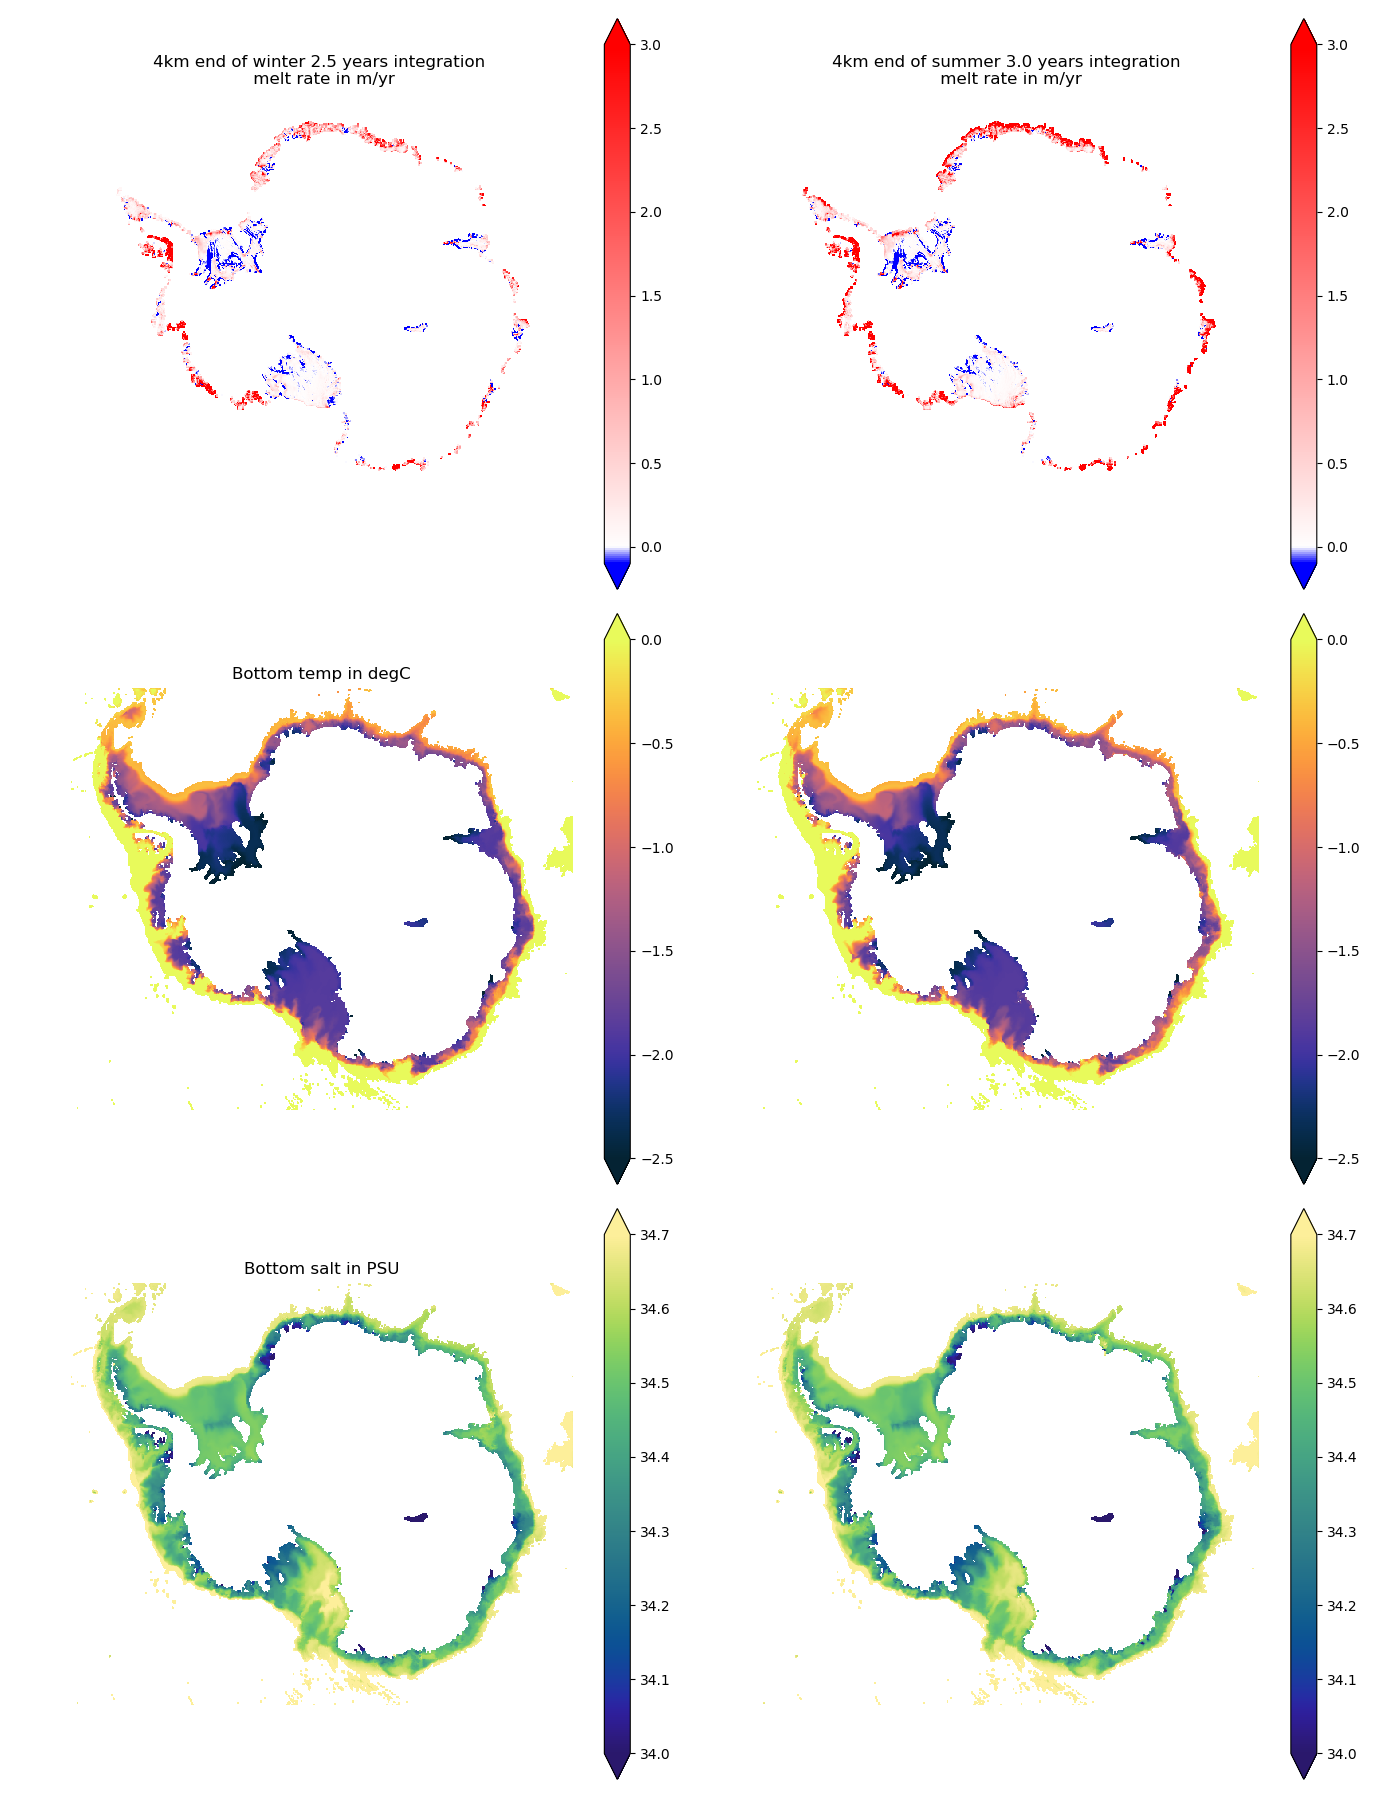

In [5]:
%matplotlib notebook


plt.close()

m_min=-0.1
m_max=3
m_cmap = shiftedColorMap(plt.cm.bwr,midpoint= (1 - m_max/(m_max + abs(m_min))))

t_min = -2.5
t_max = 0
t_cmap = ocm.thermal

s_min = 34
s_max = 34.7
s_cmap = ocm.haline


fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(14,18))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()

winter.m.where((grd_hr.zice < 0.0)&(grd_hr.mask_rho==1)).plot(ax=ax1,vmin=m_min,vmax=m_max,cmap=m_cmap)
ax1.set_title('4km end of winter 2.5 years integration \n melt rate in m/yr')
summer.m.where((grd_hr.zice < 0.0)&(grd_hr.mask_rho==1)).plot(ax=ax2,vmin=m_min,vmax=m_max,cmap=m_cmap)
ax2.set_title('4km end of summer 3.0 years integration \n melt rate in m/yr')

winter.temp[0].where((grd_hr.mask_rho==1) & (grd_hr.h<2500)).plot(ax=ax3,vmin=t_min,vmax=t_max,cmap=t_cmap)
ax3.set_title('Bottom temp in degC')
summer.temp[0].where((grd_hr.mask_rho==1) & (grd_hr.h<2500)).plot(ax=ax4,vmin=t_min,vmax=t_max,cmap=t_cmap)
ax4.set_title('')

winter.salt[0].where((grd_hr.mask_rho==1) & (grd_hr.h<2500)).plot(ax=ax5,vmin=s_min,vmax=s_max,cmap=s_cmap)
ax5.set_title('Bottom salt in PSU')
summer.salt[0].where((grd_hr.mask_rho==1) & (grd_hr.h<2500)).plot(ax=ax6,vmin=s_min,vmax=s_max,cmap=s_cmap)
ax6.set_title('')

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
fig.tight_layout()
plt.show()

In [18]:
plt.close()

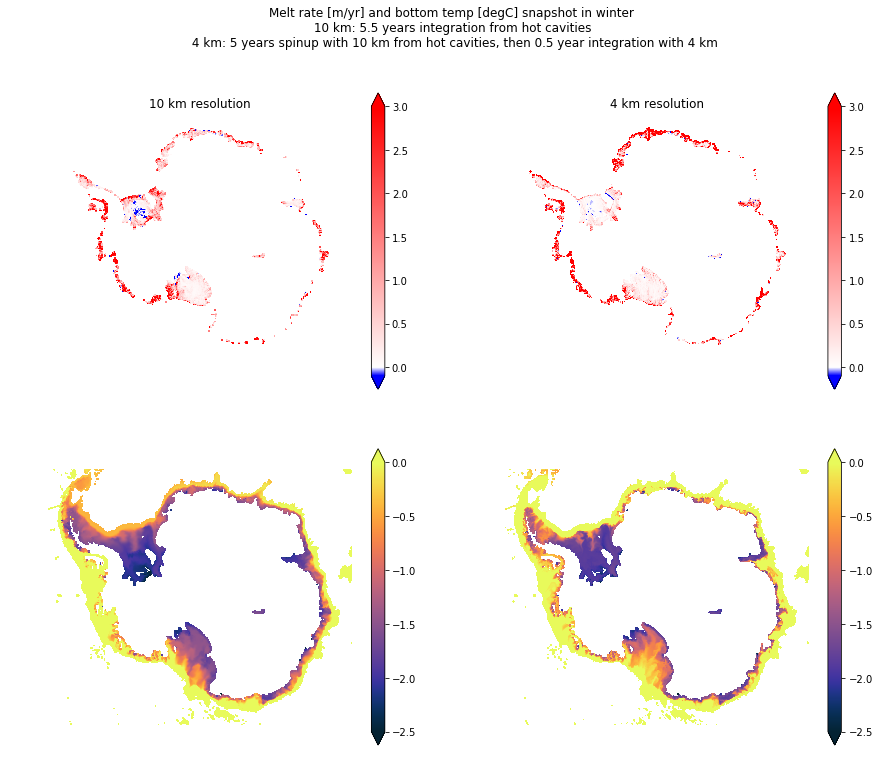

In [24]:
%matplotlib inline
plt.close()
#eta = slice(310,370)
#xi = range(470,570)
m_min=-0.1
m_max=3
m_cmap = shiftedColorMap(plt.cm.bwr,midpoint= (1 - m_max/(m_max + abs(m_min))))

t_min = -2.5
t_max = 0
t_cmap = ocm.thermal


fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Melt rate [m/yr] and bottom temp [degC] snapshot in winter \n 10 km: 5.5 years integration from hot cavities \n 4 km: 5 years spinup with 10 km from hot cavities, then 0.5 year integration with 4 km')
hot.m[9].where((grd.zice < 0.0)&(grd.mask_rho==1)).plot(ax=ax1,vmin=m_min,vmax=m_max,cmap=m_cmap)
ax1.set_title('10 km resolution')
hot_hr.m[1].where((grd_hr.zice < 0.0)&(grd_hr.mask_rho==1)).plot(ax=ax2,vmin=m_min,vmax=m_max,cmap=m_cmap)
ax2.set_title('4 km resolution')
hot.temp[-1,0].where((grd.mask_rho==1) & (grd.h<2500)).plot(ax=ax3,vmin=t_min,vmax=t_max,cmap=t_cmap)
ax3.set_title('')
hot_hr.temp[-1,0].where((grd_hr.mask_rho==1) & (grd_hr.h<2500)).plot(ax=ax4,vmin=t_min,vmax=t_max,cmap=t_cmap)
ax4.set_title('')
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_aspect('equal')
    ax.axis('off')
#fig.tight_layout()
plt.show()